<a href="https://colab.research.google.com/github/scobos65/Parcial-2-IA-Santiago-Cobos-Juan-Sebastian-Sierra-Daniela-Herrera/blob/main/Parcial%202%20IA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## PARCIAL 2 IA ##

In [ ]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import copy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix



# Punto 1.1 Cargar los datos
#Extraer columnas
with open("adult.names", "r") as f:
    lines = f.readlines()

# Filtrar las líneas que tienen el patrón "nombre: "
column_names = []
for line in lines:
    if ":" in line and not line.startswith("|"):  # Evitamos comentarios
        name = line.split(":")[0].strip()
        column_names.append(name)

# Agregar la variable objetivo (que aparece arriba, no en la lista)
column_names.append("income")

# Cargar datos de entrenamiento
train_df = pd.read_csv("adult.data", header=None, names=column_names, na_values=" ?", sep=",\\s*", engine='python')
# Cargar datos de prueba
test_df = pd.read_csv("adult.test", header=None, names=column_names, na_values=" ?", sep=",\\s*", engine='python', skiprows=1)
# Arreglar income en test_df (viene con un punto al final, por ejemplo '>50K.')
test_df["income"] = test_df["income"].str.replace(".", "", regex=False)

# Imputar valores nulos
for col in ['workclass', 'occupation', 'native-country']:
    train_df[col].fillna('Unknown', inplace=True)
    test_df[col].fillna('Unknown', inplace=True)

# Punto 1.2
# 50% validación, 50% prueba
val_df, final_test_df = train_test_split(test_df, test_size=0.5, random_state=42, stratify=test_df["income"]) # mantiene balance de clases

# Punto 1.3
# Info general
print(train_df.info())
print(train_df.describe(include="all"))

# Revisar valores faltantes o desconocidos
print("\nValores nulos por columna:")
print(train_df.isnull().sum())

# Distribución de income (variables target)
print(train_df["income"].value_counts(normalize=True))


# Punto 1.4
# Copiamos para no dañar los originales
train_processed = train_df.copy()
val_processed = val_df.copy()
test_processed = final_test_df.copy()

# Codificación de la variable target
#Primero se crea un diccionario que asigna 0 si gana menos de 50k y 1 si gana más, luego se aplica a los datos
target_map = {"<=50K": 0, ">50K": 1}
train_processed["income"] = train_processed["income"].map(target_map)
val_processed["income"] = val_processed["income"].map(target_map)
test_processed["income"] = test_processed["income"].map(target_map)

# Identificar variables
# Buscamos todas las columnas que son tipo object y las guardamos en la lista categorical_cols
categorical_cols = train_processed.select_dtypes(include=["object"]).columns.tolist()
#Luego se hace una lista con todas las variables numéricas
numeric_cols = train_processed.select_dtypes(include=["int64", "float64"]).columns.tolist()
numeric_cols.remove("income") # Excepto el target

# Codificación de variables categóricas
# Usamos OneHotEncoder en lugar de LabelEncoder porque:
# No asigna números arbitrarios que puedan interpretarse como orden.
# Convierte cada categoría en una columna binaria (dummy).
# Evita que el modelo “piense” que una categoría es mayor o menor que otra.
ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
#Transformar
train_cat = ohe.fit_transform(train_processed[categorical_cols]) # solo con train
val_cat = ohe.transform(val_processed[categorical_cols])
test_cat = ohe.transform(test_processed[categorical_cols])


# Normalización de variables numéricas
scaler = StandardScaler()
train_num = scaler.fit_transform(train_processed[numeric_cols]) # solo con train para evitar leakage
val_num = scaler.transform(val_processed[numeric_cols])
test_num = scaler.transform(test_processed[numeric_cols])

#Concatenar numéricas + categóricas
X_train = np.hstack([train_num, train_cat])
X_val = np.hstack([val_num, val_cat])
X_test = np.hstack([test_num, test_cat])

y_train = train_processed["income"].values
y_val = val_processed["income"].values
y_test = test_processed["income"].values

# Convertir a tensores de PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# DataLoaders
batch_size = 128
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


/tmp/ipython-input-4075032002.py:42: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df[col].fillna('Unknown', inplace=True)
/tmp/ipython-input-4075032002.py:43: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usi

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB
None
                 age workclass        fnlwgt education  education-num  \
count   32561.0

In [ ]:
# Punto 2.1 Modelo logistico
# ===========================================
# Punto 2.1: Baseline - Regresión Logística
# ===========================================

# Configuración "rápida": solver 'liblinear' para evitar timeouts del entorno
logreg = LogisticRegression(
    penalty="l2",
    C=1.0,
    solver="liblinear",
    max_iter=500
)
logreg.fit(X_train, y_train)

def evaluate_model(model, X, y, split_name):
    y_prob = model.predict_proba(X)[:, 1]
    y_pred = (y_prob >= 0.5).astype(int)
    metrics = {
        "split": split_name,
        "accuracy": accuracy_score(y, y_pred),
        "precision": precision_score(y, y_pred, zero_division=0),
        "recall": recall_score(y, y_pred, zero_division=0),
        "f1": f1_score(y, y_pred, zero_division=0),
        "roc_auc": roc_auc_score(y, y_prob)
    }
    cm = confusion_matrix(y, y_pred)
    return metrics, cm

metrics_train, cm_train = evaluate_model(logreg, X_train, y_train, "train")
metrics_val,   cm_val   = evaluate_model(logreg, X_val,   y_val,   "val")
metrics_test,  cm_test  = evaluate_model(logreg, X_test,  y_test,  "test")

metrics_df = pd.DataFrame([metrics_train, metrics_val, metrics_test])

print("Punto 2.1 listo ✅")
print(metrics_df)
print("\nMatrices de confusión (tn, fp; fn, tp):")
print("Train:\n", cm_train)
print("Val:\n", cm_val)
print("Test:\n", cm_test)

# Guardado de artefactos
# You can save the trained model and confusion matrices if needed
# with open("/mnt/data/logreg_baseline.pkl", "wb") as f:
#     pickle.dump(logreg, f)
# np.savez("/mnt/data/logreg_conf_mats.npz", cm_train=cm_train, cm_val=cm_val, cm_test=cm_test)

# print("\nArtefactos guardados:")
# print("- /mnt/data/eda_point1_summary.json") # This file was not created in the notebook
# print("- /mnt/data/adult_preprocessed_arrays.npz") # This file was not created in the notebook
# print("- /mnt/data/column_transformer.pkl") # This file was not created in the notebook
# print("- /mnt/data/logreg_baseline.pkl")
# print("- /mnt/data/logreg_conf_mats.npz")

Punto 2.1 listo ✅
   split  accuracy  precision    recall        f1   roc_auc
0  train  0.853106   0.738088  0.604515  0.664657  0.908713
1    val  0.847666   0.716825  0.587103  0.645512  0.899473
2   test  0.858371   0.743363  0.611544  0.671041  0.911332

Matrices de confusión (tn, fp; fn, tp):
Train:
 [[23038  1682]
 [ 3101  4740]]
Val:
 [[5771  446]
 [ 794 1129]]
Test:
 [[5812  406]
 [ 747 1176]]


Epoch 10/50, Train Loss: 0.4345, Val Loss: 0.4753
Epoch 20/50, Train Loss: 0.4152, Val Loss: 0.4826
Epoch 30/50, Train Loss: 0.3982, Val Loss: 0.4991
Epoch 40/50, Train Loss: 0.3807, Val Loss: 0.5177
Epoch 50/50, Train Loss: 0.3653, Val Loss: 0.5308


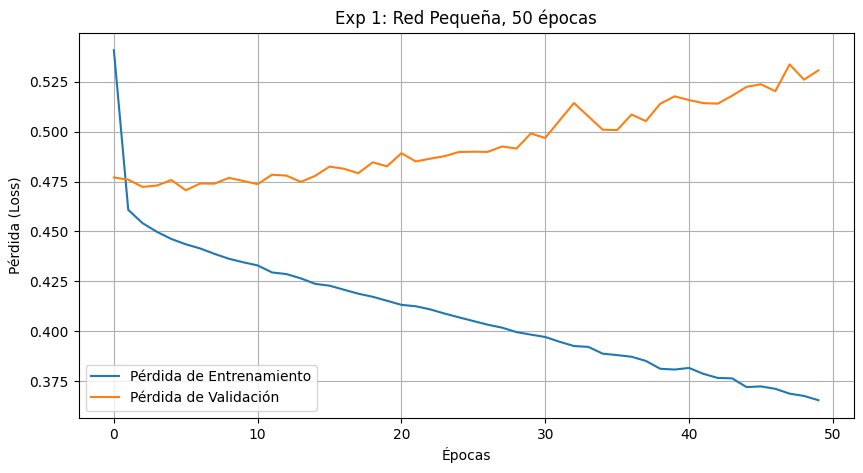

------------------------------
Epoch 10/100, Train Loss: 0.4202, Val Loss: 0.4802
Epoch 20/100, Train Loss: 0.3809, Val Loss: 0.5292
Epoch 30/100, Train Loss: 0.3351, Val Loss: 0.6646
Epoch 40/100, Train Loss: 0.2955, Val Loss: 0.9147
Epoch 50/100, Train Loss: 0.2708, Val Loss: 0.9938
Epoch 60/100, Train Loss: 0.2534, Val Loss: 1.1481
Epoch 70/100, Train Loss: 0.2404, Val Loss: 1.3384
Epoch 80/100, Train Loss: 0.2201, Val Loss: 1.5191
Epoch 90/100, Train Loss: 0.2121, Val Loss: 1.7997
Epoch 100/100, Train Loss: 0.1970, Val Loss: 1.8701


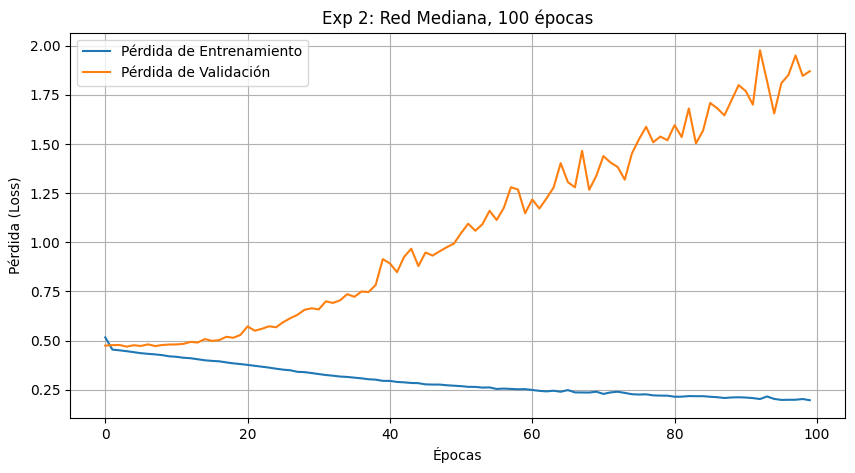

------------------------------
Epoch 10/100, Train Loss: 0.4029, Val Loss: 0.4931
Epoch 20/100, Train Loss: 0.3426, Val Loss: 0.5963
Epoch 30/100, Train Loss: 0.2934, Val Loss: 0.7947
Epoch 40/100, Train Loss: 0.2561, Val Loss: 0.9346
Epoch 50/100, Train Loss: 0.2271, Val Loss: 1.1484
Epoch 60/100, Train Loss: 0.2055, Val Loss: 1.3410
Epoch 70/100, Train Loss: 0.1866, Val Loss: 1.6181
Epoch 80/100, Train Loss: 0.1769, Val Loss: 1.8108
Epoch 90/100, Train Loss: 0.1618, Val Loss: 1.8860
Epoch 100/100, Train Loss: 0.1528, Val Loss: 2.0799


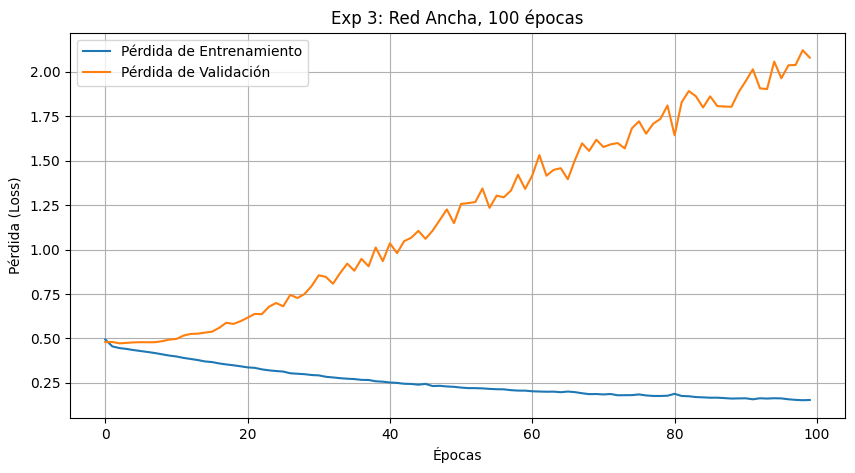

------------------------------
Epoch 10/150, Train Loss: 0.4037, Val Loss: 0.4912
Epoch 20/150, Train Loss: 0.3341, Val Loss: 0.6810
Epoch 30/150, Train Loss: 0.2767, Val Loss: 1.0484
Epoch 40/150, Train Loss: 0.2278, Val Loss: 1.4721
Epoch 50/150, Train Loss: 0.2102, Val Loss: 1.8643
Epoch 60/150, Train Loss: 0.1838, Val Loss: 1.9534
Epoch 70/150, Train Loss: 0.1727, Val Loss: 2.0740
Epoch 80/150, Train Loss: 0.1602, Val Loss: 2.2905
Epoch 90/150, Train Loss: 0.1375, Val Loss: 2.8163
Epoch 100/150, Train Loss: 0.1322, Val Loss: 2.9463
Epoch 110/150, Train Loss: 0.1261, Val Loss: 2.9818
Epoch 120/150, Train Loss: 0.1134, Val Loss: 2.9983
Epoch 130/150, Train Loss: 0.1066, Val Loss: 3.4708
Epoch 140/150, Train Loss: 0.1015, Val Loss: 3.2761
Epoch 150/150, Train Loss: 0.0958, Val Loss: 3.9152


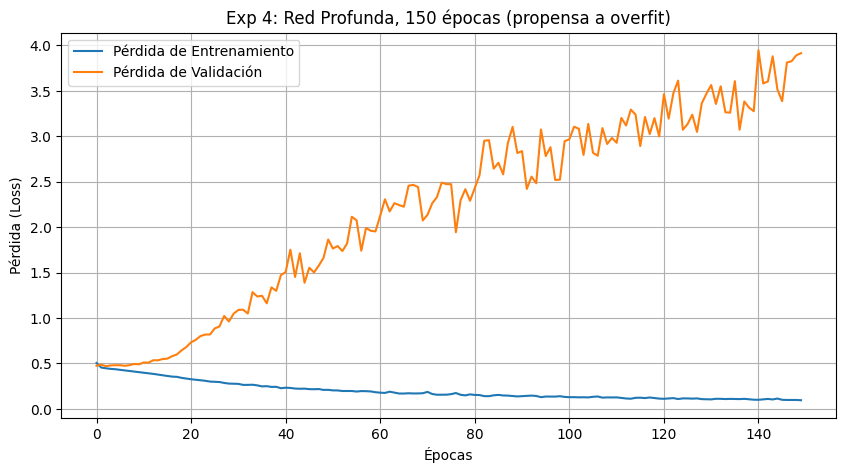

------------------------------
Epoch 10/150, Train Loss: 0.3828, Val Loss: 0.5542
Epoch 20/150, Train Loss: 0.2896, Val Loss: 0.9956
Epoch 30/150, Train Loss: 0.2273, Val Loss: 1.3938
Epoch 40/150, Train Loss: 0.2005, Val Loss: 1.6930
Epoch 50/150, Train Loss: 0.1622, Val Loss: 2.3674
Epoch 60/150, Train Loss: 0.1496, Val Loss: 2.5979
Epoch 70/150, Train Loss: 0.1485, Val Loss: 2.5911
Epoch 80/150, Train Loss: 0.1351, Val Loss: 3.0529
Epoch 90/150, Train Loss: 0.1186, Val Loss: 3.0685
Epoch 100/150, Train Loss: 0.1191, Val Loss: 3.0966
Epoch 110/150, Train Loss: 0.1112, Val Loss: 3.1241
Epoch 120/150, Train Loss: 0.1021, Val Loss: 3.3270
Epoch 130/150, Train Loss: 0.0874, Val Loss: 3.6132
Epoch 140/150, Train Loss: 0.0757, Val Loss: 3.4987
Epoch 150/150, Train Loss: 0.0771, Val Loss: 3.9908


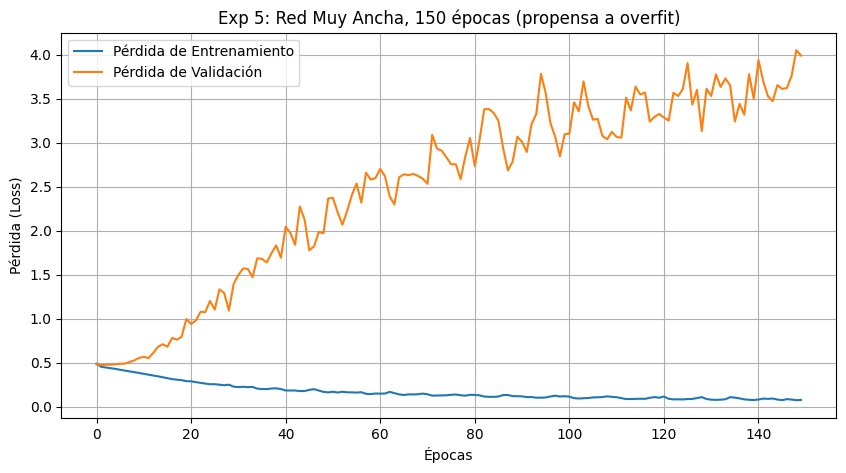

------------------------------
Epoch 10/200, Train Loss: 0.4448, Val Loss: 0.4742
Epoch 20/200, Train Loss: 0.4280, Val Loss: 0.4787
Early stopping triggered after 21 epochs!


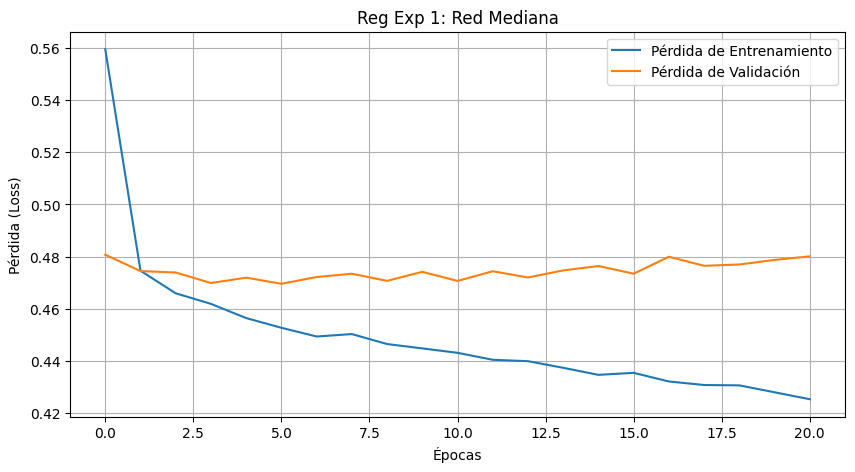

------------------------------
Epoch 10/200, Train Loss: 0.4402, Val Loss: 0.4723
Epoch 20/200, Train Loss: 0.4225, Val Loss: 0.4761
Early stopping triggered after 21 epochs!


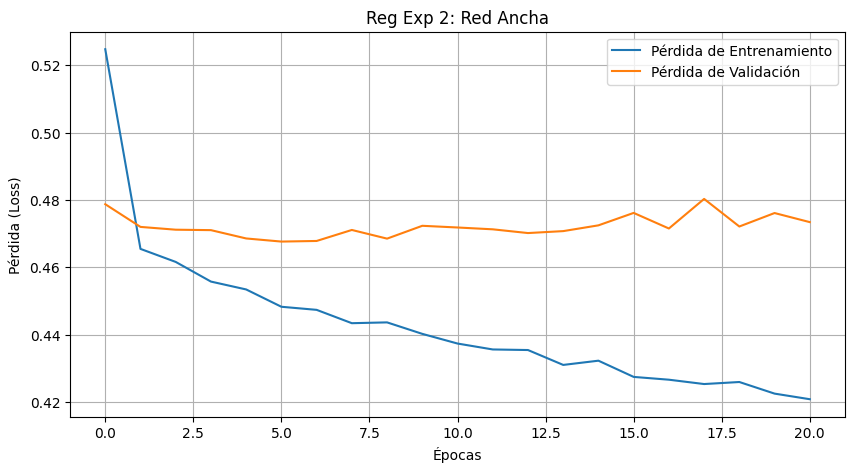

------------------------------
Epoch 10/200, Train Loss: 0.4464, Val Loss: 0.4688
Epoch 20/200, Train Loss: 0.4251, Val Loss: 0.4911
Early stopping triggered after 26 epochs!


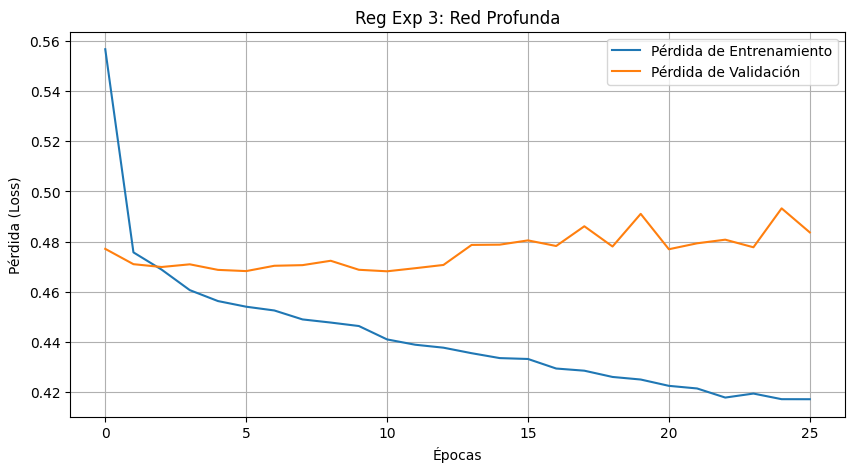

------------------------------
Epoch 10/200, Train Loss: 0.4354, Val Loss: 0.4744
Epoch 20/200, Train Loss: 0.4081, Val Loss: 0.4963
Early stopping triggered after 20 epochs!


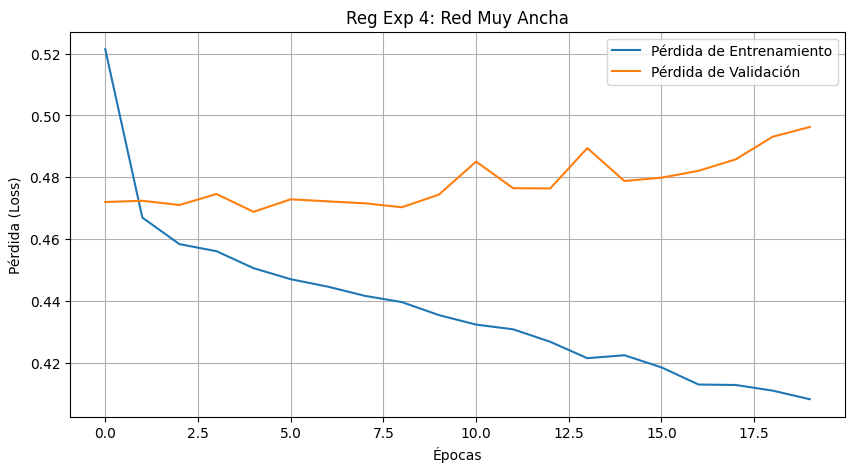

------------------------------
Epoch 10/200, Train Loss: 0.4306, Val Loss: 0.4756
Epoch 20/200, Train Loss: 0.4043, Val Loss: 0.5041
Early stopping triggered after 22 epochs!


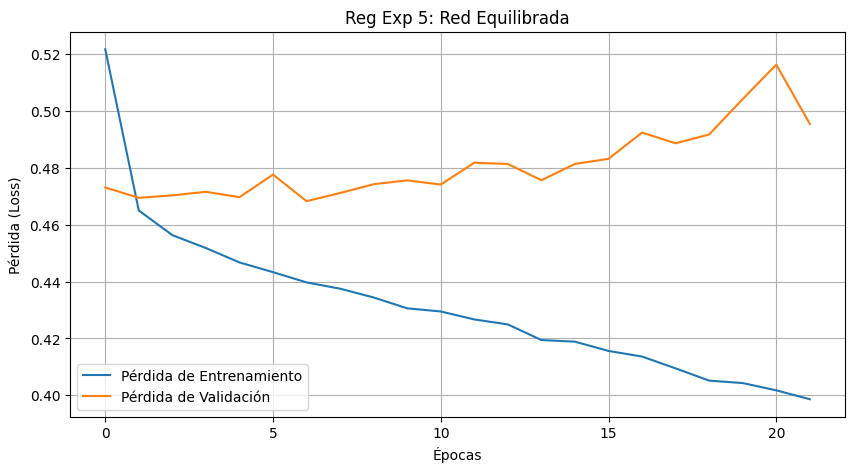

------------------------------
Modelo 'Reg Exp 1: Red Mediana' - Pérdida de Validación Final: 0.4696
Modelo 'Reg Exp 2: Red Ancha' - Pérdida de Validación Final: 0.4676
Modelo 'Reg Exp 3: Red Profunda' - Pérdida de Validación Final: 0.4682
Modelo 'Reg Exp 4: Red Muy Ancha' - Pérdida de Validación Final: 0.4688
Modelo 'Reg Exp 5: Red Equilibrada' - Pérdida de Validación Final: 0.4682

--- MÉTRICAS FINALES DEL MEJOR MODELO ---
                             loss  accuracy  precision    recall        f1  \
Entrenamiento (Train)    0.435805  0.846534   0.645966  0.802576  0.715805   
Validación (Validation)  0.467617  0.833170   0.618151  0.768591  0.685211   
Prueba (Test)            0.443587  0.849650   0.648660  0.793032  0.713617   

                          roc_auc  
Entrenamiento (Train)    0.921657  
Validación (Validation)  0.906560  
Prueba (Test)            0.917567  


In [ ]:
# Punto 2.2.1 Arquitectura base de la red neuronal
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_layers):
        super(MLP, self).__init__()
        layers = []
        in_features = input_dim
        for out_features in hidden_layers:
            layers.append(nn.Linear(in_features, out_features))
            layers.append(nn.ReLU())
            in_features = out_features
        # Capa de salida: 1 neurona (clasificación binaria)
        layers.append(nn.Linear(in_features, 1))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)


# Punto 2.2.2 Función de pérdida y optimizador y Punto 2.2.3. LOOP DE ENTRENAMIENTO CON VALIDACIÓN (SIN REGULARIZACIÓN)
def train_and_plot(model, train_loader, val_loader, learning_rate, epochs, title):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    # Calcular pos_weight (hay desbalance)
    pos_weight = torch.tensor([len(y_train) / (2 * y_train.sum())]).to(device)
    # Usamos BCEWithLogitsLoss (porque es clasificación binaria) combina la sigmoide + Binary Cross Entropy de forma numéricamente estable
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    # Adam (por defecto) es buena elección para empezar: converge rápido y requiere menos ajuste de hiperparámetros.
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    history = {"train_loss": [], "val_loss": []}

    for epoch in range(1, epochs + 1):
      # ---- Entrenamiento ----
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()  # reset gradientes
            outputs = model(inputs) # forward
            loss = criterion(outputs, labels) # calcular pérdida
            loss.backward() # retropropagación
            optimizer.step() # actualizar pesos
            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        history["train_loss"].append(epoch_loss)
        # ---- Validación ----
        val_loss = 0.0
        model.eval() #desactiva dropout, batchnorm
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

        val_loss /= len(val_loader.dataset)
        history["val_loss"].append(val_loss)

        # ---- imprimir progreso ----
        if epoch % 10 == 0:
            print(f'Epoch {epoch}/{epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}')

    # Gráfica de Pérdida vs. Épocas
    plt.figure(figsize=(10, 5))
    plt.plot(history['train_loss'], label='Pérdida de Entrenamiento')
    plt.plot(history['val_loss'], label='Pérdida de Validación')
    plt.title(title)
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida (Loss)')
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{title.replace(' ', '_')}.png")
    plt.show()
    print("-" * 30)


# Punto 2.2.4 Experimentos con distintas configuraciones de hiperparámetros

input_dim = X_train.shape[1]
experiments_no_reg = [
    {"title": "Exp 1: Red Pequeña, 50 épocas", "hidden_layers": [64, 32], "lr": 1e-3, "epochs": 50},
    {"title": "Exp 2: Red Mediana, 100 épocas", "hidden_layers": [128, 64, 32], "lr": 1e-3, "epochs": 100},
    {"title": "Exp 3: Red Ancha, 100 épocas", "hidden_layers": [256, 128], "lr": 1e-3, "epochs": 100},
    {"title": "Exp 4: Red Profunda, 150 épocas (propensa a overfit)", "hidden_layers": [256, 128, 64, 32], "lr": 1e-3, "epochs": 150},
    {"title": "Exp 5: Red Muy Ancha, 150 épocas (propensa a overfit)", "hidden_layers": [512, 256, 128], "lr": 1e-3, "epochs": 150}
]

for exp in experiments_no_reg:
    model = MLP(input_dim, exp["hidden_layers"])
    train_and_plot(model, train_loader, val_loader, exp["lr"], exp["epochs"], exp["title"])


# Punto 2.2.5 Implementar Dropout y EarlyStopping

class MLPWithDropout(nn.Module):
    def __init__(self, input_dim, hidden_layers, dropout_rates):
        super(MLPWithDropout, self).__init__()
        layers = []
        in_features = input_dim
        for i, out_features in enumerate(hidden_layers):
            layers.append(nn.Linear(in_features, out_features))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rates[i]))
            in_features = out_features
        layers.append(nn.Linear(in_features, 1))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

def train_with_regularization(model, train_loader, val_loader, learning_rate, epochs, title, patience=15):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    pos_weight = torch.tensor([len(y_train) / (2 * y_train.sum())]).to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5) # L2 regularization

    history = {"train_loss": [], "val_loss": []}
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(1, epochs + 1):
        # Entrenamiento
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        history["train_loss"].append(epoch_loss)

        # Validación
        val_loss = 0.0
        model.eval()
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

        val_loss /= len(val_loader.dataset)
        history["val_loss"].append(val_loss)

        if epoch % 10 == 0:
            print(f'Epoch {epoch}/{epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f'Early stopping triggered after {epoch} epochs!')
                break

    model.load_state_dict(best_model_wts)

    plt.figure(figsize=(10, 5))
    plt.plot(history['train_loss'], label='Pérdida de Entrenamiento')
    plt.plot(history['val_loss'], label='Pérdida de Validación')
    plt.title(title)
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida (Loss)')
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{title.replace(' ', '_')}.png")
    plt.show()
    print("-" * 30)
    return model


# Punto 1.2.6 Nuevos experimentos con regularización

experiments_with_reg = [
    {"title": "Reg Exp 1: Red Mediana", "hidden_layers": [128, 64, 32], "dropouts": [0.4, 0.3, 0.2], "lr": 8e-4, "epochs": 200},
    {"title": "Reg Exp 2: Red Ancha", "hidden_layers": [256, 128], "dropouts": [0.5, 0.4], "lr": 8e-4, "epochs": 200},
    {"title": "Reg Exp 3: Red Profunda", "hidden_layers": [256, 128, 64, 32], "dropouts": [0.5, 0.4, 0.3, 0.2], "lr": 7e-4, "epochs": 200},
    {"title": "Reg Exp 4: Red Muy Ancha", "hidden_layers": [512, 256, 128], "dropouts": [0.5, 0.4, 0.3], "lr": 7e-4, "epochs": 200},
    {"title": "Reg Exp 5: Red Equilibrada", "hidden_layers": [300, 150, 75], "dropouts": [0.4, 0.3, 0.2], "lr": 8e-4, "epochs": 200}
]


best_model = None
best_model_val_loss = float('inf')

all_models = []
for exp in experiments_with_reg:
    model = MLPWithDropout(input_dim, exp["hidden_layers"], exp["dropouts"])
    trained_model = train_with_regularization(model, train_loader, val_loader, exp["lr"], exp["epochs"], exp["title"])
    all_models.append((exp["title"], trained_model))

# Punto 2.2.7 Métricas de clasificación binaria del mejor modelo

def evaluate_pytorch_model(model, loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    y_true, y_pred_probs, val_loss = [], [], 0.0

    pos_weight = torch.tensor([len(y_train) / (2 * y_train.sum())]).to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            probs = torch.sigmoid(outputs)
            y_pred_probs.extend(probs.cpu().numpy())
            y_true.extend(labels.cpu().numpy())

    avg_loss = val_loss / len(loader.dataset)
    y_true = np.array(y_true)
    y_pred_probs = np.array(y_pred_probs)
    y_pred = (y_pred_probs > 0.5).astype(int)

    metrics = {
        "loss": avg_loss,
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred),
        "recall": recall_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred),
        "roc_auc": roc_auc_score(y_true, y_pred_probs)
    }
    return metrics

# Encontrar el mejor modelo basado en la pérdida de validación final
best_model_title = ""
for title, model in all_models:
    val_metrics = evaluate_pytorch_model(model, val_loader)
    print(f"Modelo '{title}' - Pérdida de Validación Final: {val_metrics['loss']:.4f}")
    if val_metrics['loss'] < best_model_val_loss:
        best_model_val_loss = val_metrics['loss']
        best_model = model
        best_model_title = title

# Evaluar el mejor modelo en los tres conjuntos de datos
train_metrics = evaluate_pytorch_model(best_model, train_loader)
val_metrics = evaluate_pytorch_model(best_model, val_loader)
test_metrics = evaluate_pytorch_model(best_model, test_loader)

results_df = pd.DataFrame([train_metrics, val_metrics, test_metrics],
                          index=['Entrenamiento (Train)', 'Validación (Validation)', 'Prueba (Test)'])

print("\n--- MÉTRICAS FINALES DEL MEJOR MODELO ---")
print(results_df)